In [62]:
import numpy as np
import torch 
from torchvision import datasets,transforms
import torch.nn as nn
import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
import numpy as np

DenseLayer


In [63]:
class DenseLayer:
    def __init__(self, input_size, output_size, optimizer=None):
    
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.biases = np.zeros((1, output_size))
        self.optimizer = optimizer

        if self.optimizer is not None:
            self.optimizer.parameters = [self.weights, self.biases]

    def forward(self, X):
        self.input = X
        return np.dot(X, self.weights) + self.biases

    def backward(self, grad_output):
        
        grad_weights = np.dot(self.input.T, grad_output)  
        grad_biases = np.sum(grad_output, axis=0, keepdims=True)  
        grad_input = np.dot(grad_output, self.weights.T) 

        if self.optimizer is not None:
            self.optimizer.update([grad_weights, grad_biases])

        return grad_input


BatchNormalization

In [ ]:
class BatchNormalization:
    def __init__(self, input_size, momentum=0.9, epsilon=1e-5, optimizer=None):
        self.gamma = np.ones((1, input_size))
        self.beta = np.zeros((1, input_size))
        self.running_mean = np.zeros((1, input_size))
        self.running_var = np.zeros((1, input_size))
        self.momentum = momentum
        self.epsilon = epsilon
        self.optimizer = optimizer

        if self.optimizer is not None:
            self.optimizer.parameters = [self.gamma, self.beta]

    def forward(self, X, training=True):
    
        if training:
            
            self.batch_mean = np.mean(X, axis=0, keepdims=True)
            self.batch_var = np.var(X, axis=0, keepdims=True)

            self.X_centered = X - self.batch_mean
            self.std_inv = 1.0 / np.sqrt(self.batch_var + self.epsilon)
            self.X_normalized = self.X_centered * self.std_inv

            out = self.gamma * self.X_normalized + self.beta

            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.batch_var
        else:
            
            X_centered = X - self.running_mean
            X_normalized = X_centered / np.sqrt(self.running_var + self.epsilon)
            out = self.gamma * X_normalized + self.beta

        return out

    def backward(self, grad_output):
    
        N, D = grad_output.shape

        grad_gamma = np.sum(grad_output * self.X_normalized, axis=0, keepdims=True)
        grad_beta = np.sum(grad_output, axis=0, keepdims=True)

        # Gradients with respect to the input
        grad_X_normalized = grad_output * self.gamma
        grad_var = np.sum(grad_X_normalized * self.X_centered * -0.5 * self.std_inv**3, axis=0, keepdims=True)
        grad_mean = (np.sum(grad_X_normalized * -self.std_inv, axis=0, keepdims=True) +
                     grad_var * np.mean(-2.0 * self.X_centered, axis=0, keepdims=True))
        grad_input = (grad_X_normalized * self.std_inv +
                      grad_var * 2.0 * self.X_centered / N +
                      grad_mean / N)

        if self.optimizer is not None:
            self.optimizer.update([grad_gamma, grad_beta])

        return grad_input


Adam Optimizer

In [ ]:
class Adam:
    def __init__(self, parameters, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0 

        self.m = [np.zeros_like(param) for param in self.parameters]
        self.v = [np.zeros_like(param) for param in self.parameters]

    def update(self, gradients):
        self.t += 1
        for i, param in enumerate(self.parameters):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * gradients[i]
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (gradients[i] ** 2)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            param -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)


CrossEntropyLoss


In [ ]:
class CrossEntropyLoss:
    def forward(self, predictions, labels):
        self.batch_size = labels.shape[0]
        self.predictions = predictions
        self.labels = labels
        
        loss = -np.sum(labels * np.log(predictions + 1e-9)) / self.batch_size
        return loss

    def backward(self):
        grad = (self.predictions - self.labels) / self.batch_size
        return grad


Softmax 

In [ ]:
class Softmax:
    def forward(self, X):

        exps = np.exp(X - np.max(X, axis=1, keepdims=True))  
        self.output = exps / np.sum(exps, axis=1, keepdims=True)
        return self.output

    def backward(self, grad_output):
        return grad_output


Dropout

In [ ]:
class Dropout:
    def __init__(self, dropout_rate):
        
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, X, training=True):
        
        if training:
            self.mask = np.random.binomial(1, 1 - self.dropout_rate, size=X.shape) / (1 - self.dropout_rate)
            return X * self.mask
        #else:
            #return X  

    def backward(self, grad_output):
        return grad_output * self.mask


RELU 

In [ ]:
class ReLU:
    def forward(self, X):
        self.input = X
        return np.maximum(0, X)

    def backward(self, grad_output):
        grad_input = grad_output.copy()
        grad_input[self.input <= 0] = 0
        return grad_input


NeuralNetwork Implementation

In [ ]:
class FeedForwardNeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.5):
        self.layers = []
        self.dropout_prob = dropout_prob

        dense1 = DenseLayer(input_size, hidden_sizes[0])
        bn1 = BatchNormalization(hidden_sizes[0])
        self.layers.append(dense1)
        self.layers.append(bn1)
        self.layers.append(ReLU())
        self.layers.append(Dropout(dropout_prob))
 
        dense1.optimizer = Adam(parameters=[dense1.weights, dense1.biases], learning_rate=0.001)
        bn1.optimizer = Adam(parameters=[bn1.gamma, bn1.beta], learning_rate=0.001)

        
        for i in range(len(hidden_sizes) - 1):
            dense = DenseLayer(hidden_sizes[i], hidden_sizes[i + 1])
            bn = BatchNormalization(hidden_sizes[i + 1])
            self.layers.append(dense)
            self.layers.append(bn)
            self.layers.append(ReLU())
            self.layers.append(Dropout(dropout_prob))

            
            dense.optimizer = Adam(parameters=[dense.weights, dense.biases], learning_rate=0.001)
            bn.optimizer = Adam(parameters=[bn.gamma, bn.beta], learning_rate=0.001)

        
        output_layer = DenseLayer(hidden_sizes[-1], output_size)
        self.layers.append(output_layer)
        self.layers.append(Softmax())

       
        output_layer.optimizer = Adam(parameters=[output_layer.weights, output_layer.biases], learning_rate=0.001)
    
    def  get_weights(self):
        weights = {}
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'weights') and hasattr(layer, 'biases'):
                weights[f'layer_{i}_weights'] = layer.weights
                weights[f'layer_{i}_biases'] = layer.biases

            if isinstance(layer, BatchNormalization):
                weights[f'layer_{i}_gamma'] = layer.gamma
                weights[f'layer_{i}_beta'] = layer.beta
                weights[f'layer_{i}_moving_mean'] = layer.running_mean
                weights[f'layer_{i}_moving_var'] = layer.running_var
                weights[f'layer_{i}_epsilon'] = layer.epsilon

        return weights

    def set_weights(self, weights):
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'weights') and hasattr(layer, 'biases'):
                layer.weights = weights[f'layer_{i}_weights']
                layer.biases = weights[f'layer_{i}_biases']

            if isinstance(layer, BatchNormalization):
                layer.gamma = weights[f'layer_{i}_gamma']
                layer.beta = weights[f'layer_{i}_beta']
                layer.running_mean = weights[f'layer_{i}_moving_mean']
                layer.running_var = weights[f'layer_{i}_moving_var']
                layer.epsilon = weights[f'layer_{i}_epsilon']

    def forward(self, X, training=True):
        
        for layer in self.layers:
            if isinstance(layer, Dropout):
                X = layer.forward(X, training)
            else:
                X = layer.forward(X)
        return X

    def backward(self, grad_output):
       
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)


In [ ]:
from sklearn.metrics import f1_score, accuracy_score

class TrainNeuralNetwork:
    def __init__(self, model, learning_rate=0.001, batch_size=64):
        
        self.model = model
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.val_f1_scores = []
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.loss_fn = CrossEntropyLoss()

    def evaluate(self, data, labels):
        predictions = self.model.forward(data, training=False)
        loss = self.loss_fn.forward(predictions, labels)
        
        labels_single = np.argmax(labels, axis=1)
        predictions_single = np.argmax(predictions, axis=1)
        
        accuracy = accuracy_score(labels_single, predictions_single)
        f1 = f1_score(labels_single, predictions_single, average='macro')
        
        return loss, accuracy, f1

    def train(self, train_data, train_labels, val_data, val_labels, epochs=50):
        num_samples = train_data.shape[0]

        for epoch in range(epochs):
            
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            train_data = train_data[indices]
            train_labels = train_labels[indices]

            # Mini-batch training
            batch_losses = []
            batch_accuracies = []
            for start in range(0, num_samples, self.batch_size):
                end = start + self.batch_size
                batch_data = train_data[start:end]
                batch_labels = train_labels[start:end]

                predictions = self.model.forward(batch_data, training=True)
                loss = self.loss_fn.forward(predictions, batch_labels)
                batch_losses.append(loss)
 
                grad_loss = self.loss_fn.backward()
                self.model.backward(grad_loss)

                batch_labels_single = np.argmax(batch_labels, axis=1)
                predictions_single = np.argmax(predictions, axis=1)
                accuracy = (predictions_single == batch_labels_single).mean()
                batch_accuracies.append(accuracy)

            train_loss = np.mean(batch_losses)
            train_accuracy = np.mean(batch_accuracies)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)

            val_loss, val_accuracy, val_f1 = self.evaluate(val_data, val_labels)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)
            self.val_f1_scores.append(val_f1)

            print(f"Epoch {epoch + 1}/{epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")


In [ ]:
import matplotlib.pyplot as plt

def plot_training_metrics(trainer):
    
    epochs = range(1, len(trainer.train_losses) + 1)
  
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, trainer.train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, trainer.val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy vs. Epochs')
    plt.legend()

    # Subplot 2: Training and Validation Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, trainer.train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, trainer.val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss vs. Epochs')
    plt.legend()

    # Subplot 3: Validation F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(epochs, trainer.val_f1_scores, label='Validation F1 Score', marker='o', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score vs. Epochs')
    plt.legend()

    # Adjust layout and display plots
    plt.tight_layout()
    plt.show()


In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


Training model with architecture <__main__.FeedForwardNeuralNetwork object at 0x000001669D8B34D0> and learning rate 0.005
Epoch 1/30, Train Loss: 0.6676, Train Acc: 0.8147, Val Loss: 0.4050, Val Acc: 0.8543, Val F1: 0.8564
Epoch 2/30, Train Loss: 0.3827, Train Acc: 0.8642, Val Loss: 0.3460, Val Acc: 0.8732, Val F1: 0.8733
Epoch 3/30, Train Loss: 0.3379, Train Acc: 0.8795, Val Loss: 0.3333, Val Acc: 0.8799, Val F1: 0.8801
Epoch 4/30, Train Loss: 0.3148, Train Acc: 0.8861, Val Loss: 0.3194, Val Acc: 0.8858, Val F1: 0.8857
Epoch 5/30, Train Loss: 0.2952, Train Acc: 0.8930, Val Loss: 0.3148, Val Acc: 0.8857, Val F1: 0.8861
Epoch 6/30, Train Loss: 0.2775, Train Acc: 0.8995, Val Loss: 0.3195, Val Acc: 0.8822, Val F1: 0.8831
Epoch 7/30, Train Loss: 0.2624, Train Acc: 0.9025, Val Loss: 0.3024, Val Acc: 0.8921, Val F1: 0.8927
Epoch 8/30, Train Loss: 0.2498, Train Acc: 0.9085, Val Loss: 0.3096, Val Acc: 0.8858, Val F1: 0.8869
Epoch 9/30, Train Loss: 0.2390, Train Acc: 0.9118, Val Loss: 0.2938, V

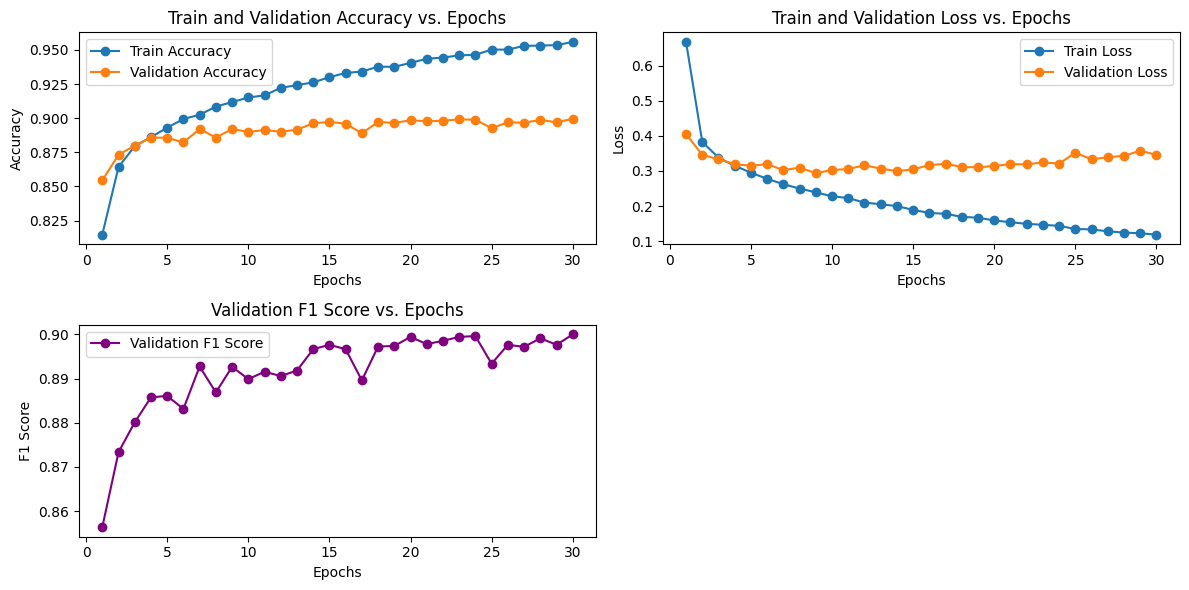

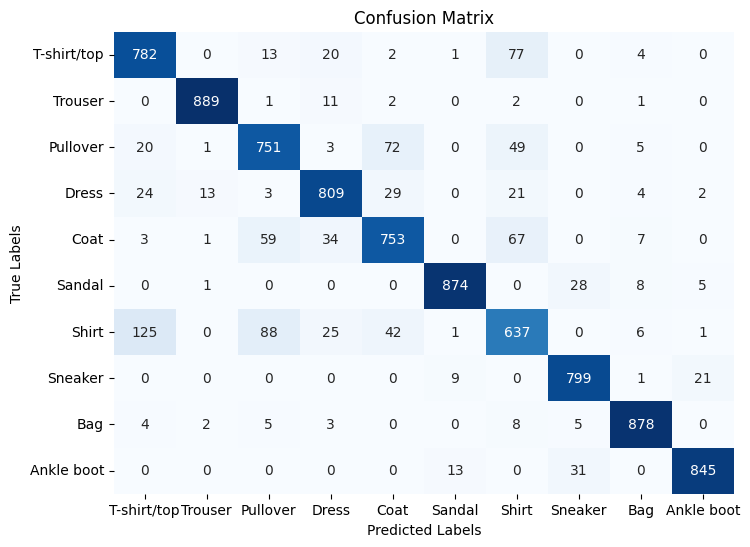

Training model with architecture <__main__.FeedForwardNeuralNetwork object at 0x000001669D96F1D0> and learning rate 0.005
Epoch 1/30, Train Loss: 0.6733, Train Acc: 0.8158, Val Loss: 0.3937, Val Acc: 0.8608, Val F1: 0.8610
Epoch 2/30, Train Loss: 0.3859, Train Acc: 0.8632, Val Loss: 0.3616, Val Acc: 0.8673, Val F1: 0.8664
Epoch 3/30, Train Loss: 0.3433, Train Acc: 0.8755, Val Loss: 0.3300, Val Acc: 0.8802, Val F1: 0.8814
Epoch 4/30, Train Loss: 0.3186, Train Acc: 0.8845, Val Loss: 0.3241, Val Acc: 0.8812, Val F1: 0.8803
Epoch 5/30, Train Loss: 0.2981, Train Acc: 0.8910, Val Loss: 0.3098, Val Acc: 0.8868, Val F1: 0.8867
Epoch 6/30, Train Loss: 0.2867, Train Acc: 0.8937, Val Loss: 0.3095, Val Acc: 0.8872, Val F1: 0.8876
Epoch 7/30, Train Loss: 0.2720, Train Acc: 0.8983, Val Loss: 0.3137, Val Acc: 0.8842, Val F1: 0.8837
Epoch 8/30, Train Loss: 0.2614, Train Acc: 0.9031, Val Loss: 0.3036, Val Acc: 0.8863, Val F1: 0.8866
Epoch 9/30, Train Loss: 0.2518, Train Acc: 0.9085, Val Loss: 0.3051, V

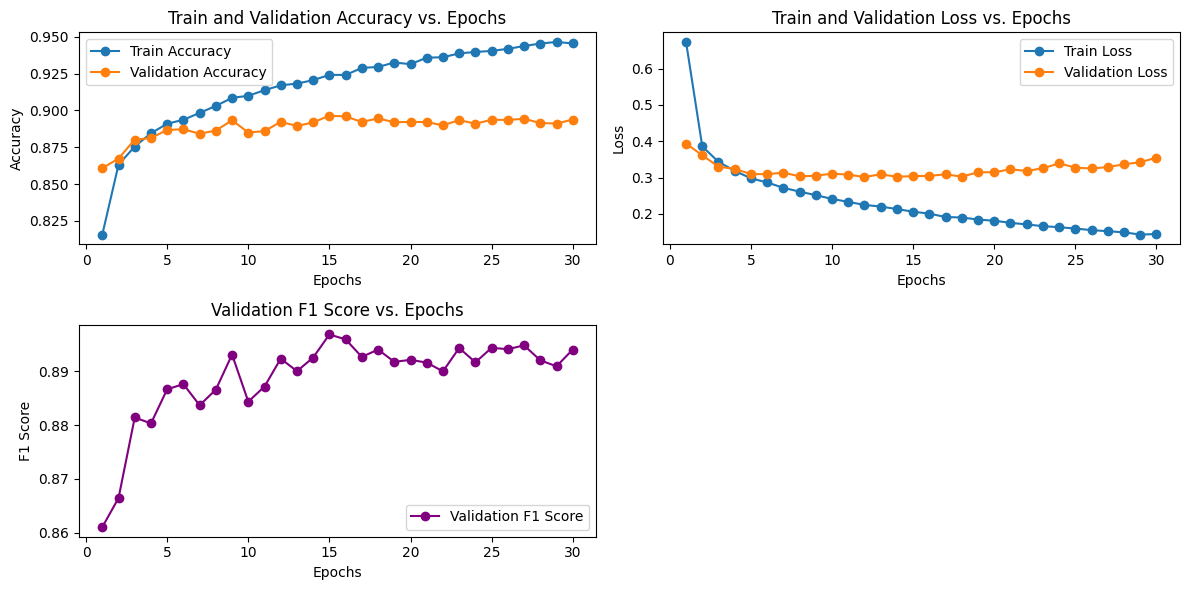

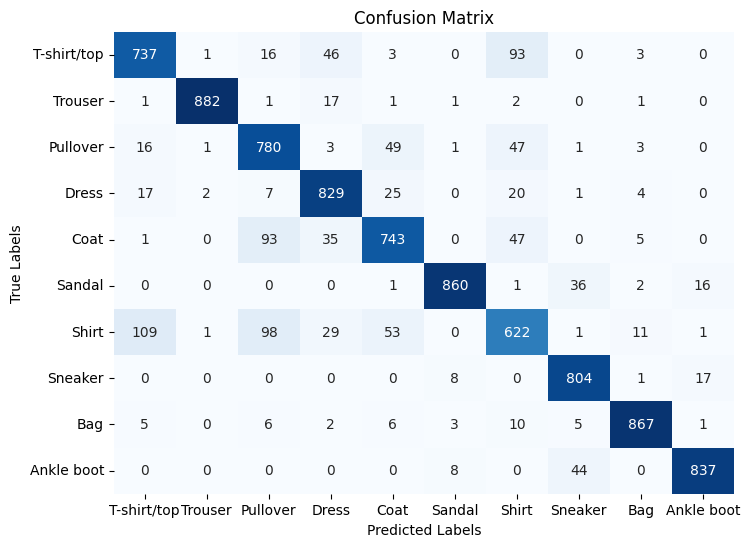

Training model with architecture <__main__.FeedForwardNeuralNetwork object at 0x000001669D912650> and learning rate 0.005
Epoch 1/30, Train Loss: 0.8536, Train Acc: 0.7904, Val Loss: 0.4363, Val Acc: 0.8546, Val F1: 0.8541
Epoch 2/30, Train Loss: 0.4267, Train Acc: 0.8570, Val Loss: 0.3789, Val Acc: 0.8660, Val F1: 0.8669
Epoch 3/30, Train Loss: 0.3770, Train Acc: 0.8705, Val Loss: 0.3415, Val Acc: 0.8788, Val F1: 0.8784
Epoch 4/30, Train Loss: 0.3456, Train Acc: 0.8811, Val Loss: 0.3308, Val Acc: 0.8790, Val F1: 0.8796
Epoch 5/30, Train Loss: 0.3215, Train Acc: 0.8870, Val Loss: 0.3266, Val Acc: 0.8846, Val F1: 0.8847
Epoch 6/30, Train Loss: 0.3002, Train Acc: 0.8941, Val Loss: 0.3172, Val Acc: 0.8892, Val F1: 0.8889
Epoch 7/30, Train Loss: 0.2887, Train Acc: 0.8991, Val Loss: 0.3101, Val Acc: 0.8901, Val F1: 0.8906
Epoch 8/30, Train Loss: 0.2787, Train Acc: 0.9018, Val Loss: 0.3018, Val Acc: 0.8923, Val F1: 0.8926
Epoch 9/30, Train Loss: 0.2644, Train Acc: 0.9059, Val Loss: 0.3088, V

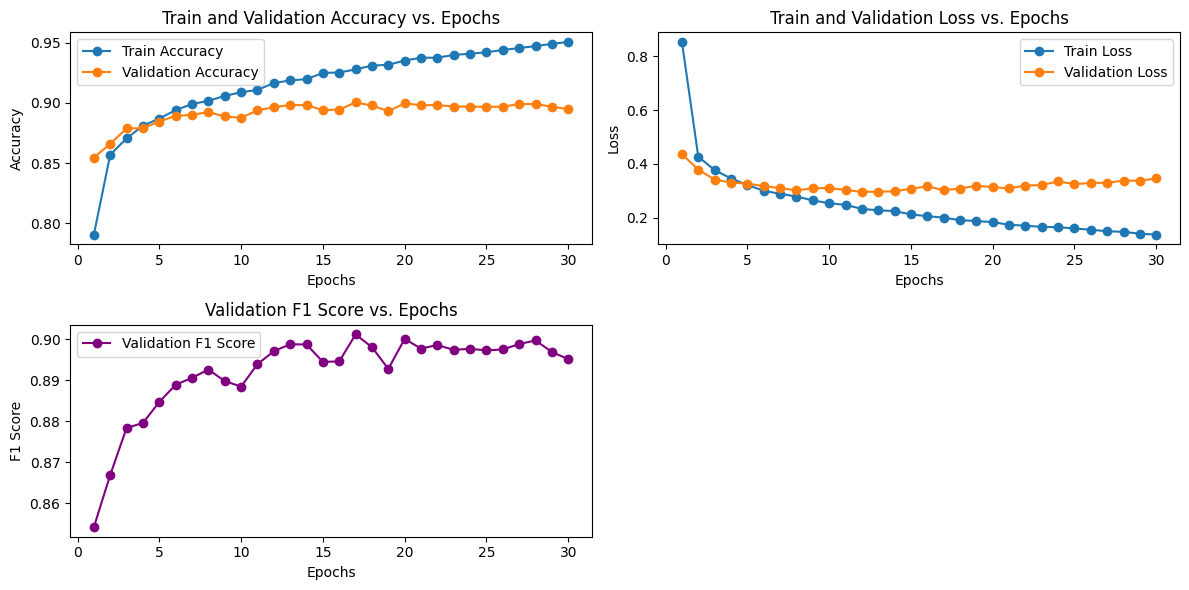

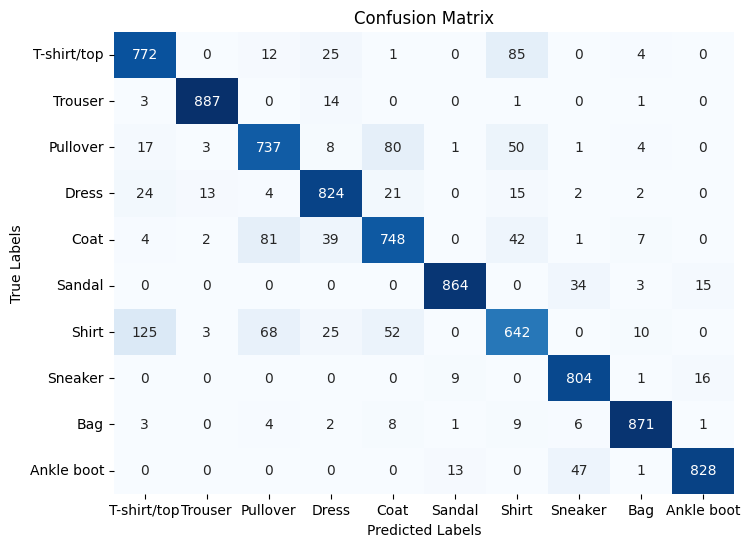

Training model with architecture <__main__.FeedForwardNeuralNetwork object at 0x000001669D8B34D0> and learning rate 0.001
Epoch 1/30, Train Loss: 0.1188, Train Acc: 0.9561, Val Loss: 0.3478, Val Acc: 0.8998, Val F1: 0.9005
Epoch 2/30, Train Loss: 0.1112, Train Acc: 0.9579, Val Loss: 0.3463, Val Acc: 0.9001, Val F1: 0.9002
Epoch 3/30, Train Loss: 0.1114, Train Acc: 0.9585, Val Loss: 0.3659, Val Acc: 0.8971, Val F1: 0.8979
Epoch 4/30, Train Loss: 0.1075, Train Acc: 0.9600, Val Loss: 0.3677, Val Acc: 0.8991, Val F1: 0.9000
Epoch 5/30, Train Loss: 0.1059, Train Acc: 0.9610, Val Loss: 0.3767, Val Acc: 0.8977, Val F1: 0.8978
Epoch 6/30, Train Loss: 0.1043, Train Acc: 0.9611, Val Loss: 0.3819, Val Acc: 0.8944, Val F1: 0.8949
Epoch 7/30, Train Loss: 0.0992, Train Acc: 0.9635, Val Loss: 0.3722, Val Acc: 0.8984, Val F1: 0.8994
Epoch 8/30, Train Loss: 0.0957, Train Acc: 0.9641, Val Loss: 0.3878, Val Acc: 0.8926, Val F1: 0.8927
Epoch 9/30, Train Loss: 0.0977, Train Acc: 0.9637, Val Loss: 0.3854, V

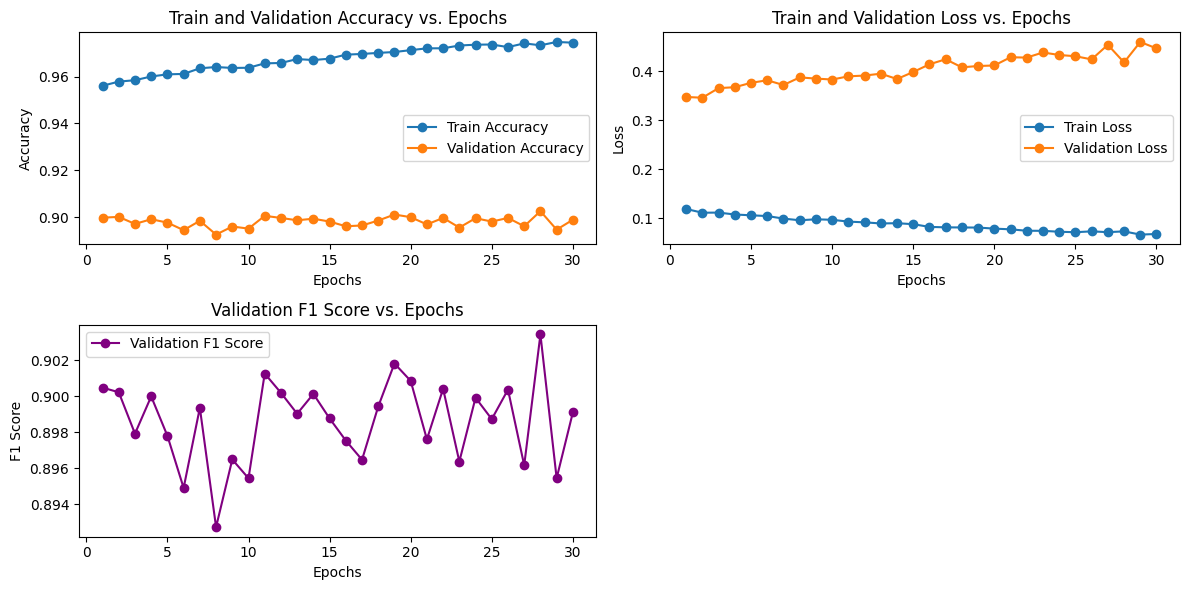

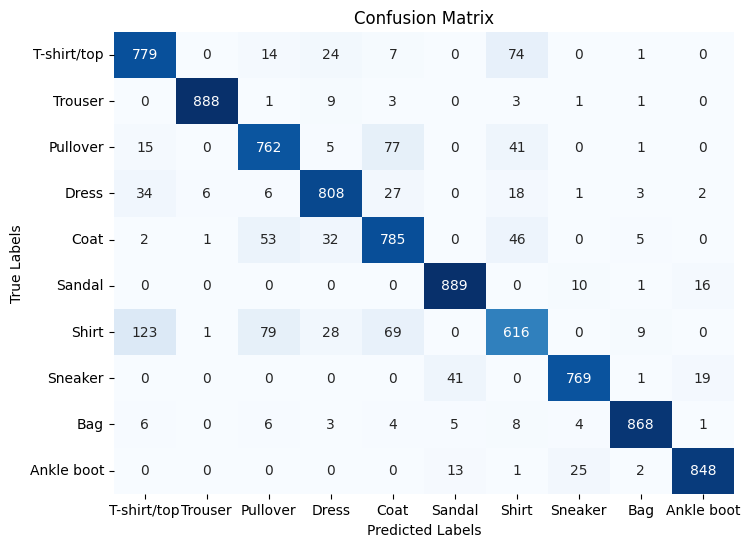

Training model with architecture <__main__.FeedForwardNeuralNetwork object at 0x000001669D96F1D0> and learning rate 0.001
Epoch 1/30, Train Loss: 0.1412, Train Acc: 0.9471, Val Loss: 0.3423, Val Acc: 0.8957, Val F1: 0.8951
Epoch 2/30, Train Loss: 0.1360, Train Acc: 0.9483, Val Loss: 0.3494, Val Acc: 0.8936, Val F1: 0.8938
Epoch 3/30, Train Loss: 0.1349, Train Acc: 0.9495, Val Loss: 0.3640, Val Acc: 0.8903, Val F1: 0.8892
Epoch 4/30, Train Loss: 0.1327, Train Acc: 0.9508, Val Loss: 0.3756, Val Acc: 0.8920, Val F1: 0.8917
Epoch 5/30, Train Loss: 0.1313, Train Acc: 0.9518, Val Loss: 0.3630, Val Acc: 0.8957, Val F1: 0.8958
Epoch 6/30, Train Loss: 0.1299, Train Acc: 0.9511, Val Loss: 0.3665, Val Acc: 0.8898, Val F1: 0.8900
Epoch 7/30, Train Loss: 0.1270, Train Acc: 0.9521, Val Loss: 0.3688, Val Acc: 0.8918, Val F1: 0.8923
Epoch 8/30, Train Loss: 0.1246, Train Acc: 0.9538, Val Loss: 0.3709, Val Acc: 0.8928, Val F1: 0.8941
Epoch 9/30, Train Loss: 0.1230, Train Acc: 0.9547, Val Loss: 0.3741, V

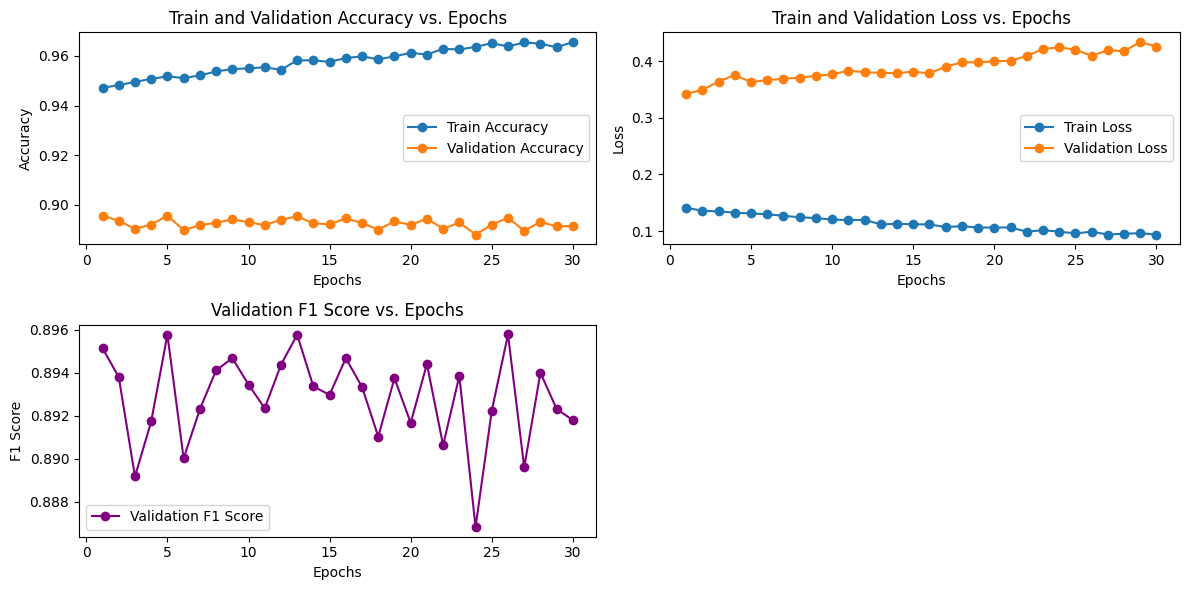

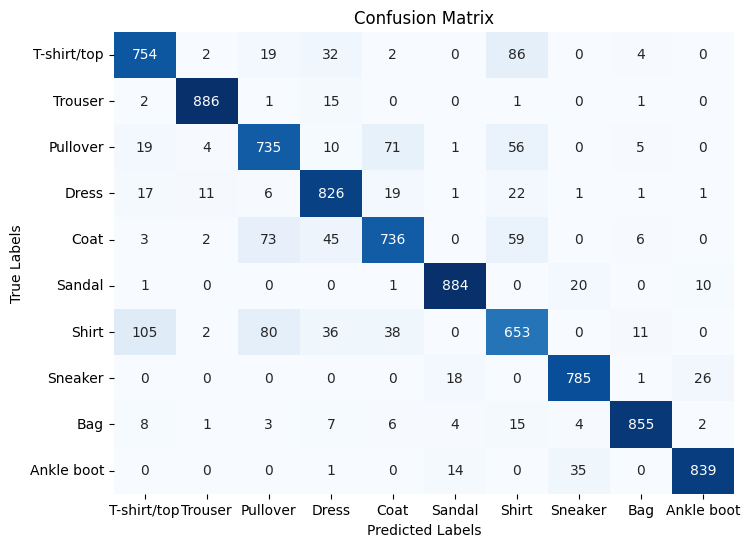

Training model with architecture <__main__.FeedForwardNeuralNetwork object at 0x000001669D912650> and learning rate 0.001
Epoch 1/30, Train Loss: 0.1381, Train Acc: 0.9497, Val Loss: 0.3434, Val Acc: 0.8938, Val F1: 0.8943
Epoch 2/30, Train Loss: 0.1346, Train Acc: 0.9518, Val Loss: 0.3406, Val Acc: 0.8993, Val F1: 0.8994
Epoch 3/30, Train Loss: 0.1295, Train Acc: 0.9519, Val Loss: 0.3452, Val Acc: 0.8991, Val F1: 0.8996
Epoch 4/30, Train Loss: 0.1249, Train Acc: 0.9548, Val Loss: 0.3536, Val Acc: 0.8984, Val F1: 0.8991
Epoch 5/30, Train Loss: 0.1262, Train Acc: 0.9552, Val Loss: 0.3541, Val Acc: 0.8994, Val F1: 0.8997
Epoch 6/30, Train Loss: 0.1242, Train Acc: 0.9557, Val Loss: 0.3608, Val Acc: 0.9009, Val F1: 0.9012
Epoch 7/30, Train Loss: 0.1170, Train Acc: 0.9568, Val Loss: 0.3638, Val Acc: 0.8979, Val F1: 0.8988
Epoch 8/30, Train Loss: 0.1197, Train Acc: 0.9556, Val Loss: 0.3464, Val Acc: 0.9014, Val F1: 0.9018
Epoch 9/30, Train Loss: 0.1117, Train Acc: 0.9594, Val Loss: 0.3719, V

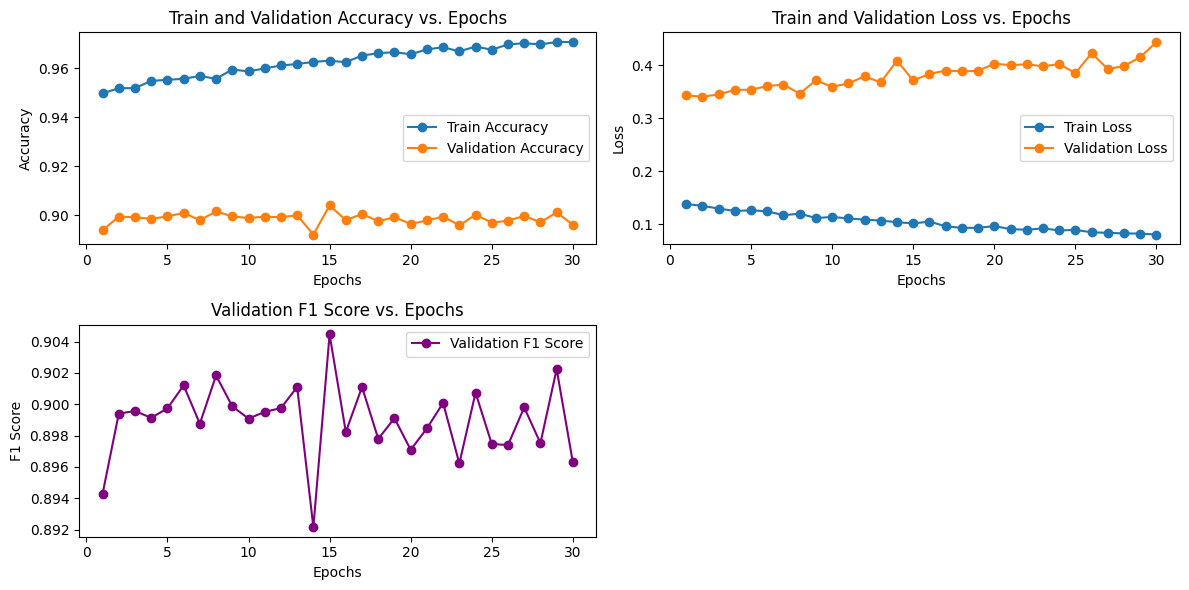

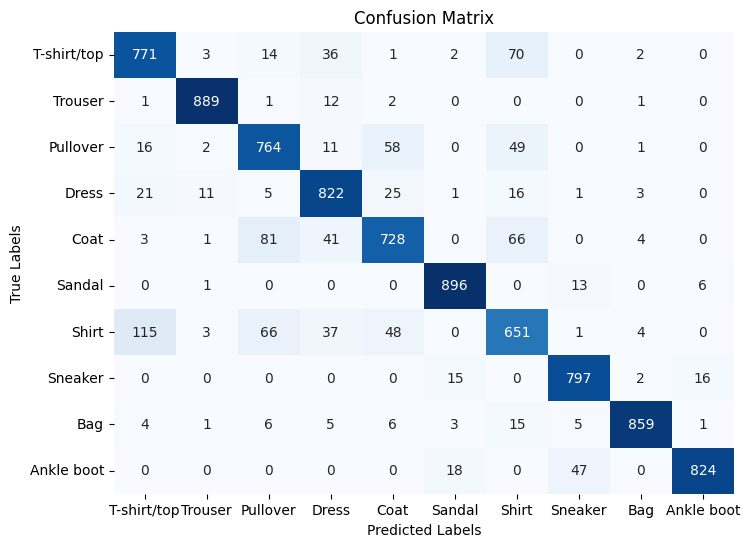

Training model with architecture <__main__.FeedForwardNeuralNetwork object at 0x000001669D8B34D0> and learning rate 0.0001
Epoch 1/30, Train Loss: 0.0663, Train Acc: 0.9753, Val Loss: 0.4544, Val Acc: 0.8953, Val F1: 0.8957
Epoch 2/30, Train Loss: 0.0615, Train Acc: 0.9772, Val Loss: 0.4424, Val Acc: 0.9002, Val F1: 0.9012
Epoch 3/30, Train Loss: 0.0650, Train Acc: 0.9761, Val Loss: 0.4555, Val Acc: 0.8977, Val F1: 0.8986
Epoch 4/30, Train Loss: 0.0648, Train Acc: 0.9765, Val Loss: 0.4477, Val Acc: 0.8983, Val F1: 0.8990
Epoch 5/30, Train Loss: 0.0607, Train Acc: 0.9787, Val Loss: 0.4648, Val Acc: 0.8981, Val F1: 0.8984
Epoch 6/30, Train Loss: 0.0623, Train Acc: 0.9767, Val Loss: 0.4679, Val Acc: 0.8916, Val F1: 0.8923
Epoch 7/30, Train Loss: 0.0610, Train Acc: 0.9782, Val Loss: 0.4511, Val Acc: 0.8982, Val F1: 0.8985
Epoch 8/30, Train Loss: 0.0597, Train Acc: 0.9778, Val Loss: 0.4802, Val Acc: 0.8962, Val F1: 0.8975
Epoch 9/30, Train Loss: 0.0610, Train Acc: 0.9776, Val Loss: 0.4584, 

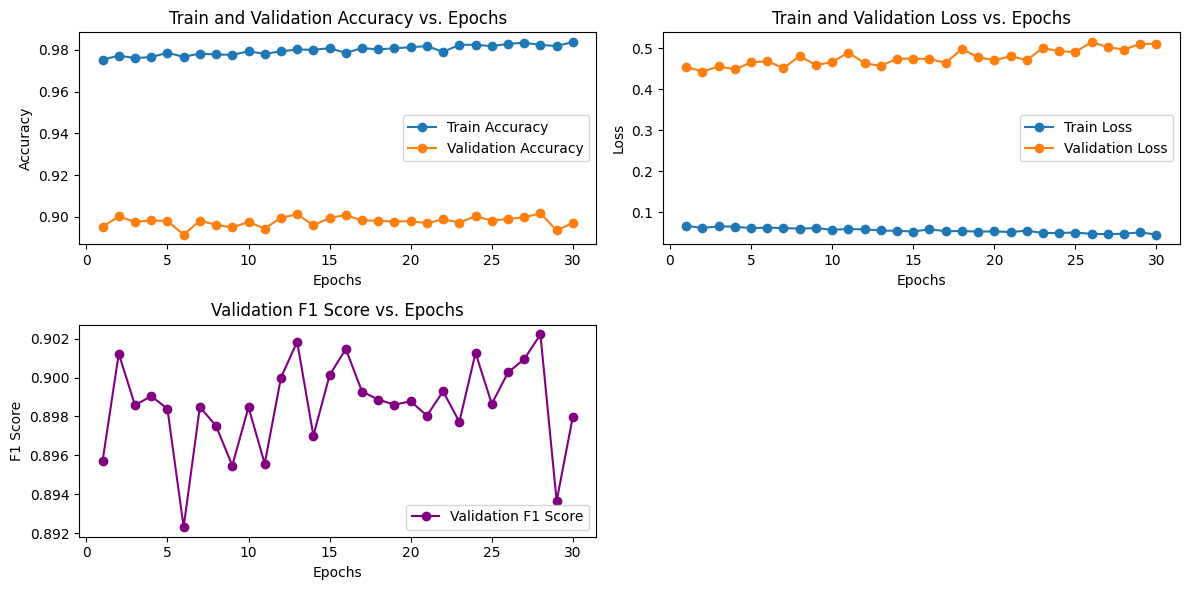

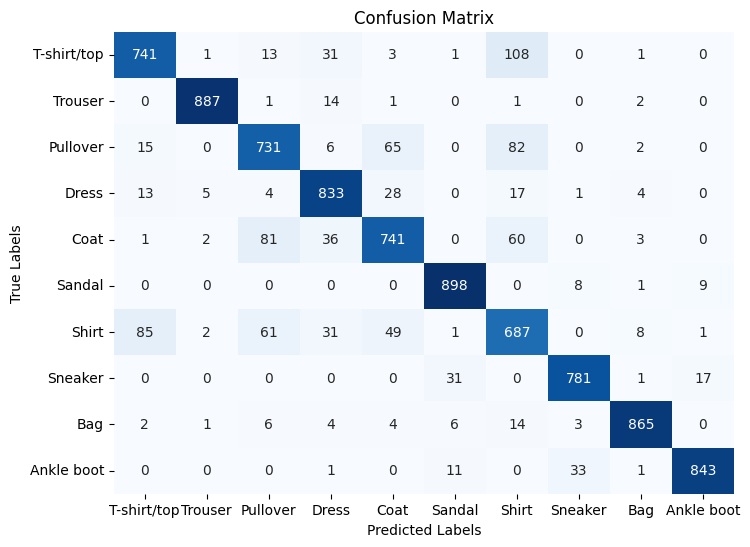

Training model with architecture <__main__.FeedForwardNeuralNetwork object at 0x000001669D96F1D0> and learning rate 0.0001
Epoch 1/30, Train Loss: 0.0919, Train Acc: 0.9665, Val Loss: 0.4215, Val Acc: 0.8949, Val F1: 0.8951
Epoch 2/30, Train Loss: 0.0904, Train Acc: 0.9665, Val Loss: 0.4272, Val Acc: 0.8894, Val F1: 0.8900
Epoch 3/30, Train Loss: 0.0909, Train Acc: 0.9667, Val Loss: 0.4196, Val Acc: 0.8931, Val F1: 0.8936
Epoch 4/30, Train Loss: 0.0852, Train Acc: 0.9691, Val Loss: 0.4548, Val Acc: 0.8927, Val F1: 0.8929
Epoch 5/30, Train Loss: 0.0893, Train Acc: 0.9660, Val Loss: 0.4422, Val Acc: 0.8912, Val F1: 0.8917
Epoch 6/30, Train Loss: 0.0865, Train Acc: 0.9683, Val Loss: 0.4375, Val Acc: 0.8916, Val F1: 0.8917
Epoch 7/30, Train Loss: 0.0872, Train Acc: 0.9670, Val Loss: 0.4404, Val Acc: 0.8942, Val F1: 0.8947
Epoch 8/30, Train Loss: 0.0847, Train Acc: 0.9688, Val Loss: 0.4495, Val Acc: 0.8919, Val F1: 0.8924
Epoch 9/30, Train Loss: 0.0837, Train Acc: 0.9691, Val Loss: 0.4508, 

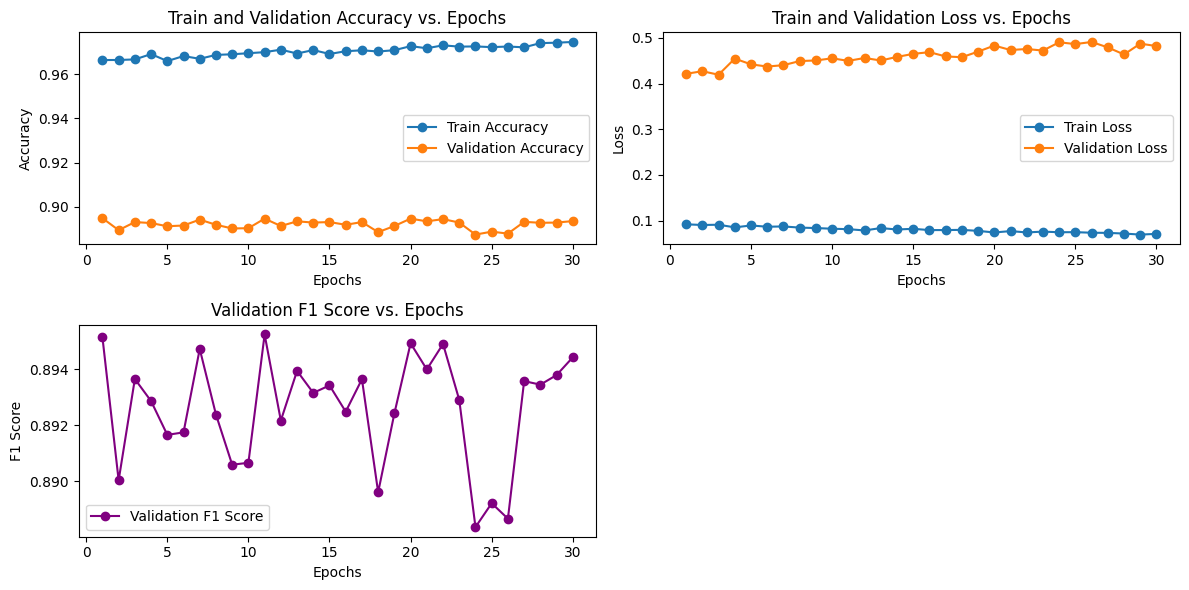

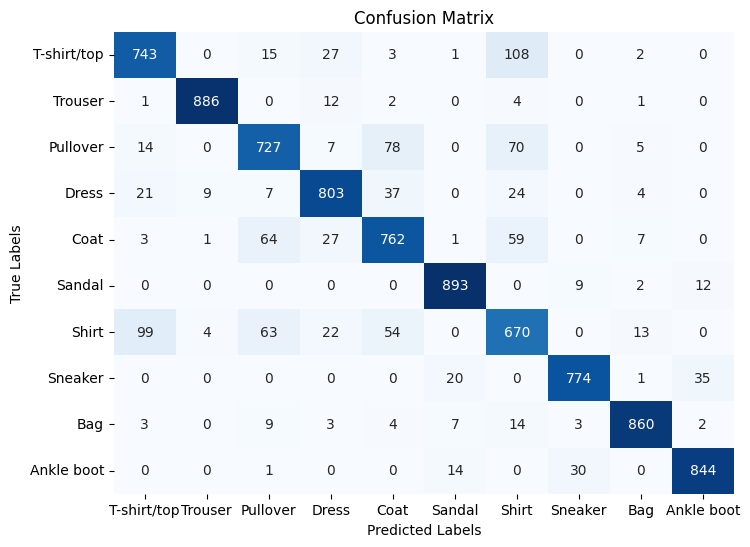

Training model with architecture <__main__.FeedForwardNeuralNetwork object at 0x000001669D912650> and learning rate 0.0001
Epoch 1/30, Train Loss: 0.0785, Train Acc: 0.9720, Val Loss: 0.4412, Val Acc: 0.9003, Val F1: 0.9007
Epoch 2/30, Train Loss: 0.0767, Train Acc: 0.9724, Val Loss: 0.4401, Val Acc: 0.8952, Val F1: 0.8962
Epoch 3/30, Train Loss: 0.0780, Train Acc: 0.9726, Val Loss: 0.4277, Val Acc: 0.8984, Val F1: 0.8991
Epoch 4/30, Train Loss: 0.0748, Train Acc: 0.9733, Val Loss: 0.4209, Val Acc: 0.8996, Val F1: 0.8999
Epoch 5/30, Train Loss: 0.0727, Train Acc: 0.9744, Val Loss: 0.4307, Val Acc: 0.8990, Val F1: 0.8997
Epoch 6/30, Train Loss: 0.0749, Train Acc: 0.9720, Val Loss: 0.4448, Val Acc: 0.8983, Val F1: 0.8988
Epoch 7/30, Train Loss: 0.0727, Train Acc: 0.9731, Val Loss: 0.4349, Val Acc: 0.8976, Val F1: 0.8981
Epoch 8/30, Train Loss: 0.0741, Train Acc: 0.9732, Val Loss: 0.4578, Val Acc: 0.8939, Val F1: 0.8945
Epoch 9/30, Train Loss: 0.0741, Train Acc: 0.9739, Val Loss: 0.4249, 

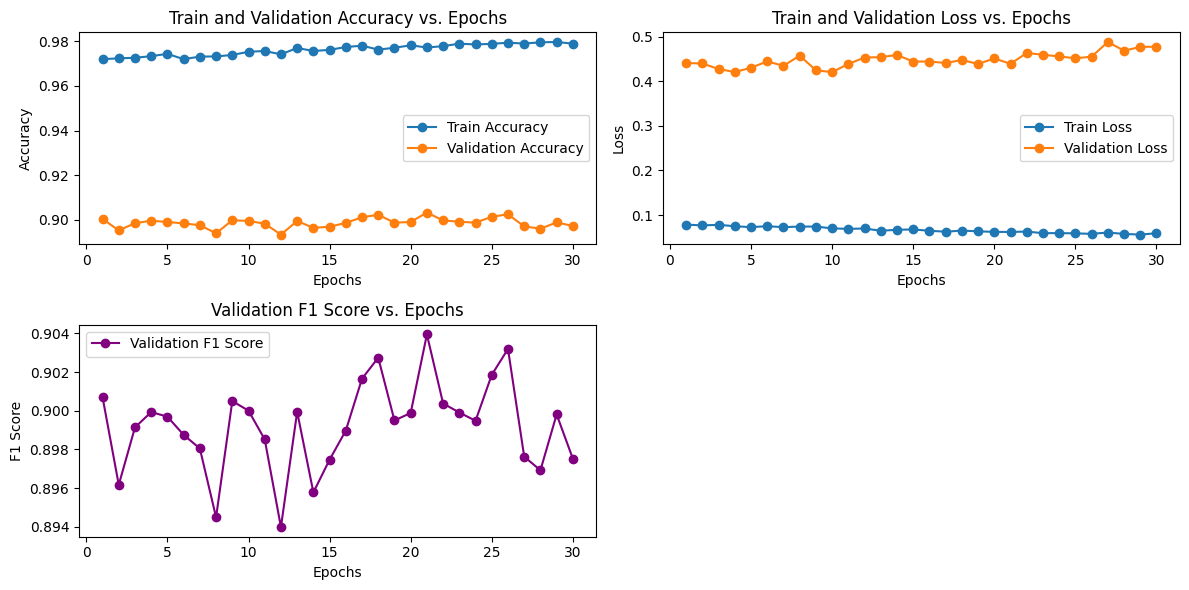

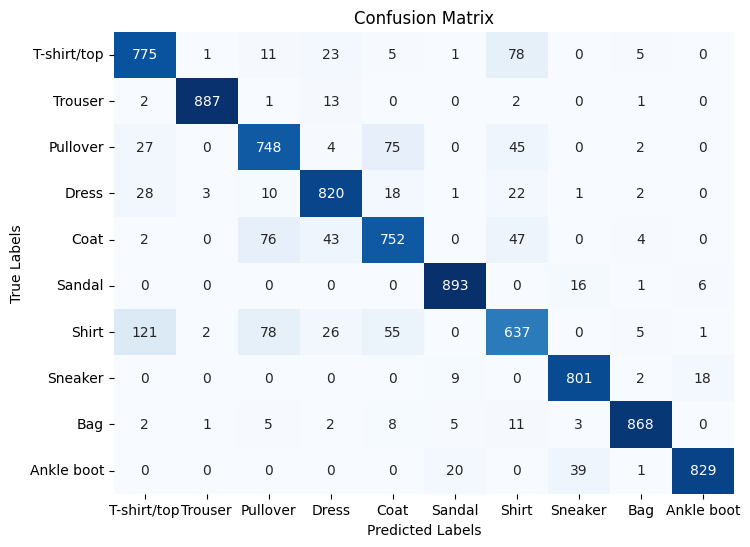

Training model with architecture <__main__.FeedForwardNeuralNetwork object at 0x000001669D8B34D0> and learning rate 1e-05
Epoch 1/30, Train Loss: 0.0450, Train Acc: 0.9844, Val Loss: 0.5084, Val Acc: 0.8981, Val F1: 0.8986
Epoch 2/30, Train Loss: 0.0446, Train Acc: 0.9836, Val Loss: 0.5083, Val Acc: 0.9008, Val F1: 0.9014
Epoch 3/30, Train Loss: 0.0457, Train Acc: 0.9831, Val Loss: 0.5056, Val Acc: 0.9001, Val F1: 0.9006
Epoch 4/30, Train Loss: 0.0457, Train Acc: 0.9835, Val Loss: 0.5052, Val Acc: 0.8983, Val F1: 0.8995
Epoch 5/30, Train Loss: 0.0423, Train Acc: 0.9849, Val Loss: 0.5038, Val Acc: 0.8971, Val F1: 0.8980
Epoch 6/30, Train Loss: 0.0442, Train Acc: 0.9843, Val Loss: 0.5164, Val Acc: 0.8988, Val F1: 0.8993
Epoch 7/30, Train Loss: 0.0477, Train Acc: 0.9830, Val Loss: 0.5142, Val Acc: 0.8977, Val F1: 0.8988
Epoch 8/30, Train Loss: 0.0463, Train Acc: 0.9831, Val Loss: 0.4931, Val Acc: 0.8982, Val F1: 0.8991
Epoch 9/30, Train Loss: 0.0404, Train Acc: 0.9853, Val Loss: 0.5120, V

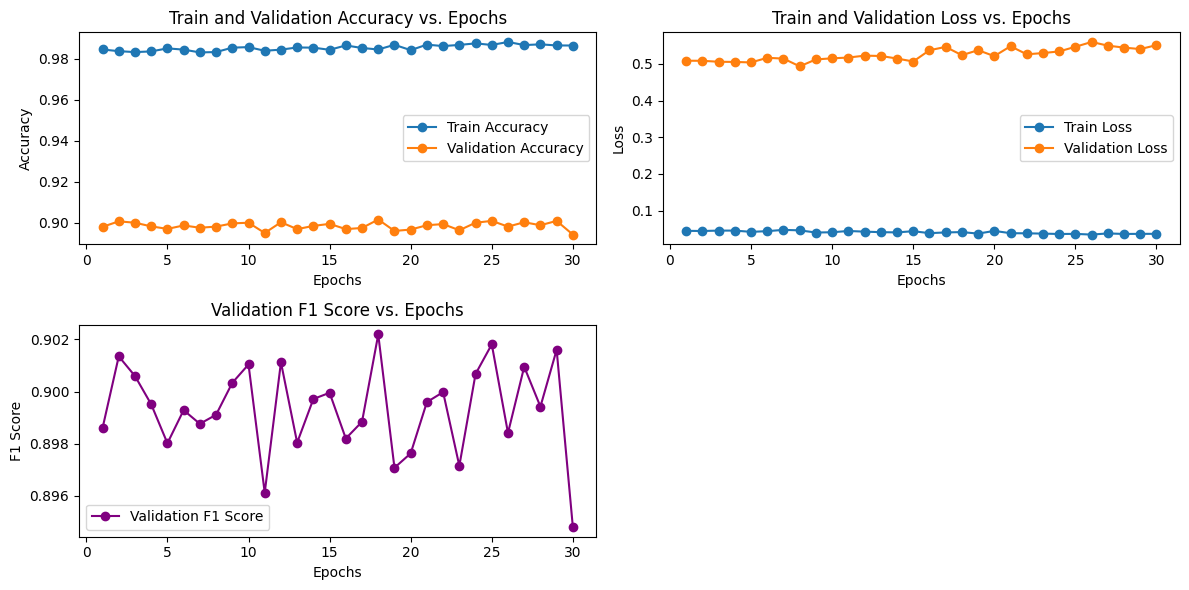

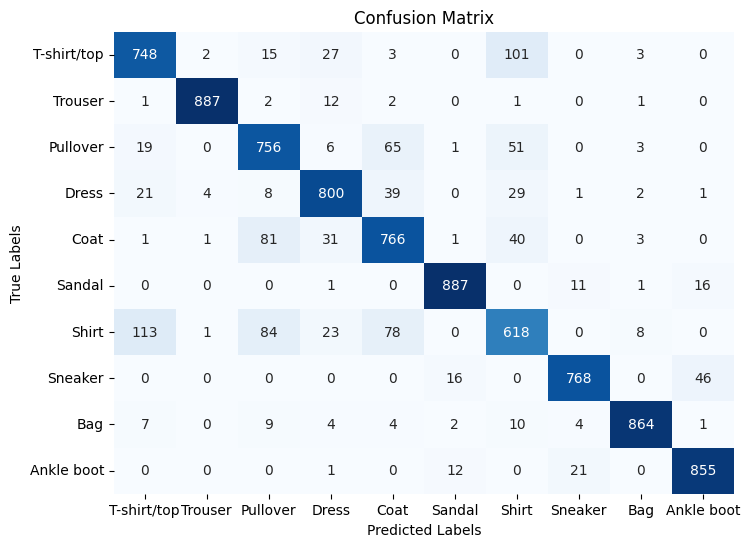

Training model with architecture <__main__.FeedForwardNeuralNetwork object at 0x000001669D96F1D0> and learning rate 1e-05
Epoch 1/30, Train Loss: 0.0686, Train Acc: 0.9751, Val Loss: 0.4856, Val Acc: 0.8900, Val F1: 0.8904
Epoch 2/30, Train Loss: 0.0705, Train Acc: 0.9738, Val Loss: 0.5026, Val Acc: 0.8883, Val F1: 0.8887
Epoch 3/30, Train Loss: 0.0671, Train Acc: 0.9755, Val Loss: 0.5005, Val Acc: 0.8917, Val F1: 0.8921
Epoch 4/30, Train Loss: 0.0710, Train Acc: 0.9738, Val Loss: 0.4697, Val Acc: 0.8936, Val F1: 0.8940
Epoch 5/30, Train Loss: 0.0664, Train Acc: 0.9760, Val Loss: 0.5102, Val Acc: 0.8913, Val F1: 0.8918
Epoch 6/30, Train Loss: 0.0691, Train Acc: 0.9751, Val Loss: 0.4969, Val Acc: 0.8912, Val F1: 0.8918
Epoch 7/30, Train Loss: 0.0669, Train Acc: 0.9756, Val Loss: 0.4844, Val Acc: 0.8939, Val F1: 0.8947
Epoch 8/30, Train Loss: 0.0683, Train Acc: 0.9754, Val Loss: 0.5044, Val Acc: 0.8904, Val F1: 0.8913
Epoch 9/30, Train Loss: 0.0646, Train Acc: 0.9764, Val Loss: 0.5008, V

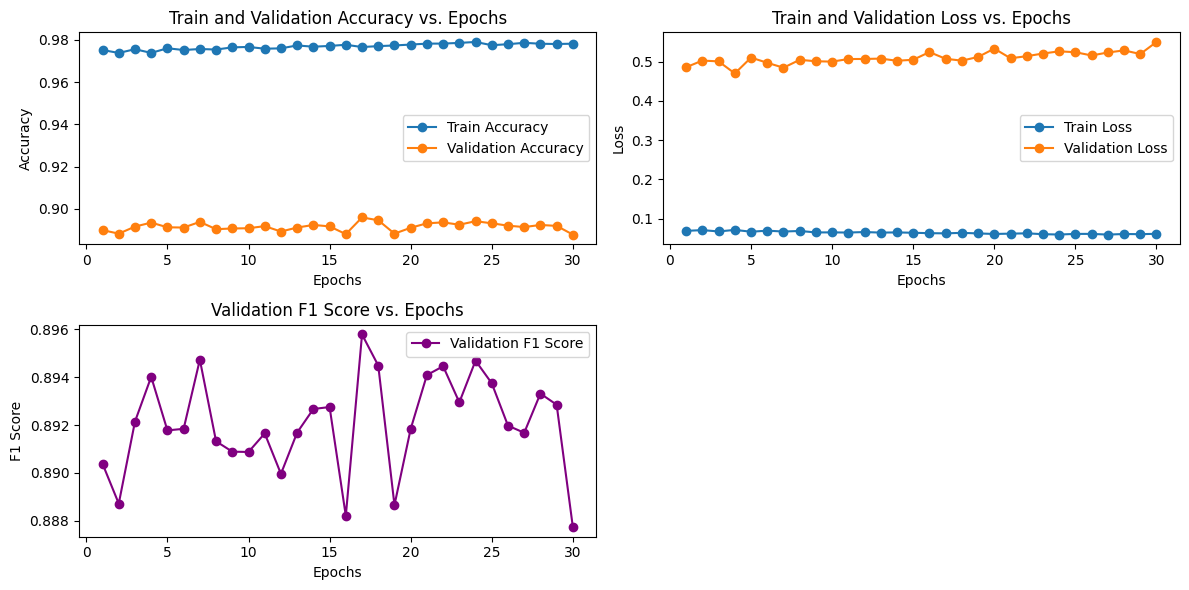

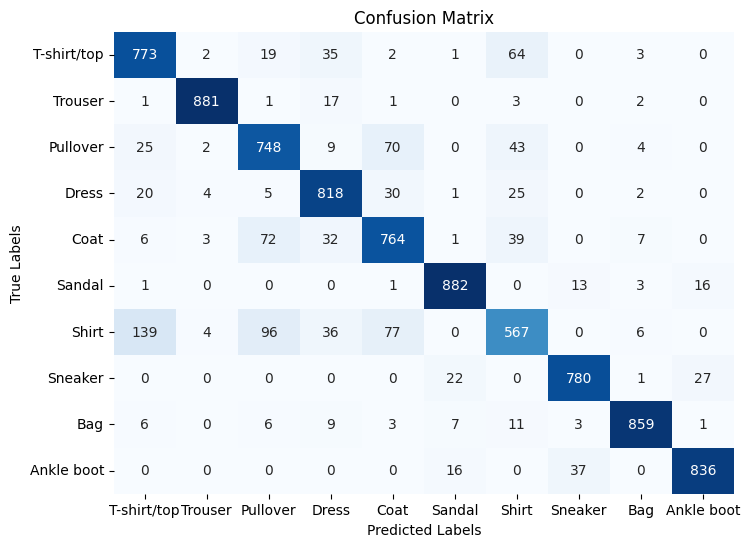

Training model with architecture <__main__.FeedForwardNeuralNetwork object at 0x000001669D912650> and learning rate 1e-05
Epoch 1/30, Train Loss: 0.0565, Train Acc: 0.9802, Val Loss: 0.4883, Val Acc: 0.9002, Val F1: 0.9006
Epoch 2/30, Train Loss: 0.0537, Train Acc: 0.9812, Val Loss: 0.4733, Val Acc: 0.8977, Val F1: 0.8979
Epoch 3/30, Train Loss: 0.0539, Train Acc: 0.9808, Val Loss: 0.4643, Val Acc: 0.8984, Val F1: 0.8992
Epoch 4/30, Train Loss: 0.0545, Train Acc: 0.9804, Val Loss: 0.4776, Val Acc: 0.8992, Val F1: 0.8997
Epoch 5/30, Train Loss: 0.0538, Train Acc: 0.9810, Val Loss: 0.4620, Val Acc: 0.9012, Val F1: 0.9020
Epoch 6/30, Train Loss: 0.0508, Train Acc: 0.9826, Val Loss: 0.4957, Val Acc: 0.8967, Val F1: 0.8975
Epoch 7/30, Train Loss: 0.0533, Train Acc: 0.9817, Val Loss: 0.4773, Val Acc: 0.9004, Val F1: 0.9009
Epoch 8/30, Train Loss: 0.0536, Train Acc: 0.9815, Val Loss: 0.4863, Val Acc: 0.8958, Val F1: 0.8960
Epoch 9/30, Train Loss: 0.0500, Train Acc: 0.9821, Val Loss: 0.5062, V

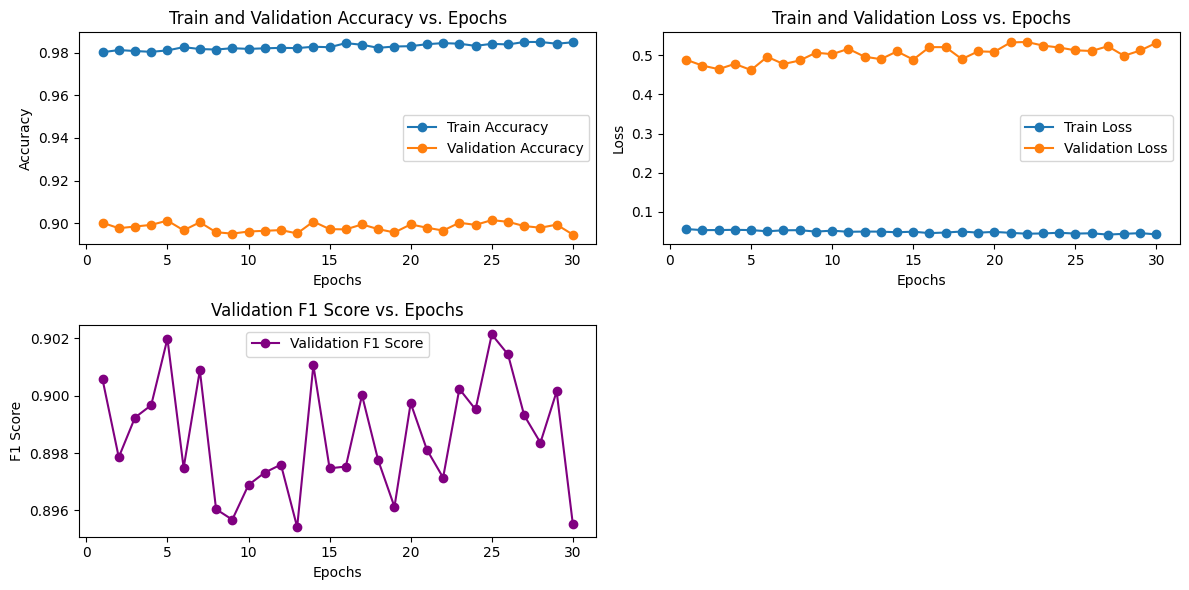

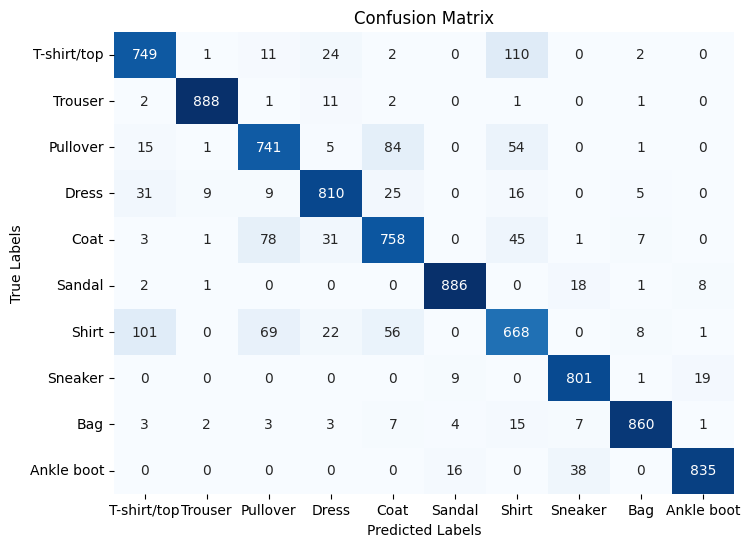

Best model selected with learning rate 0.001 and architecture <__main__.FeedForwardNeuralNetwork object at 0x000001669D912650>


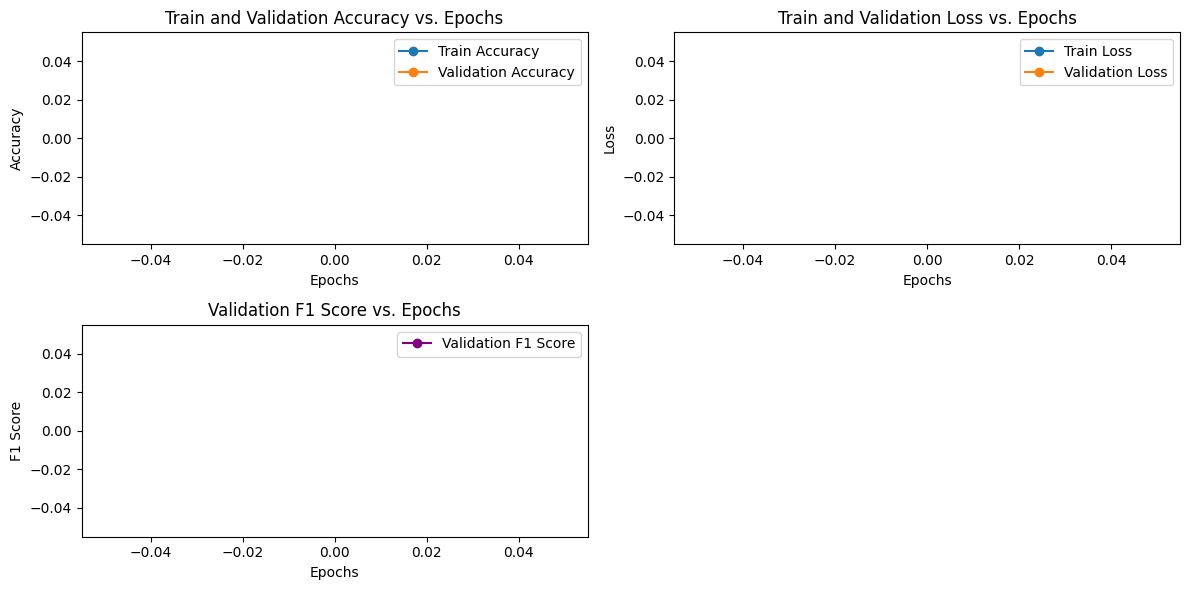

Test Accuracy: 0.8976, Test F1 Score: 0.8977995088015487
Test Confusion Matrix:
[[822   2  15  21   4   1 127   0   8   0]
 [  1 977   1  12   1   0   6   0   2   0]
 [ 22   1 810  10  77   1  77   0   2   0]
 [ 28   7  10 883  33   0  37   0   2   0]
 [  1   1  87  29 824   1  55   0   2   0]
 [  2   0   0   1   0 959   0  23   0  15]
 [102   0  80  20  67   0 725   1   5   0]
 [  0   0   0   0   0   7   0 972   0  21]
 [  5   0   9   4   2   4   1   4 971   0]
 [  0   0   0   0   0   7   1  32   0 960]]


In [ ]:
def preprocess():
    transform = transforms.ToTensor()
    train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
    
    train_data = train_dataset.data.numpy().reshape(-1, 28 * 28) / 255.0  # Normalize to [0, 1]
    train_labels = np.eye(10)[train_dataset.targets.numpy()]  # One-hot encode labels

    test_data = test_dataset.data.numpy().reshape(-1, 28 * 28) / 255.0  # Normalize to [0, 1]
    test_labels = np.eye(10)[test_dataset.targets.numpy()]  # One-hot encode labels

    return train_data, train_labels, test_data, test_labels

# Preprocess data
train_data, train_labels, test_data, test_labels = preprocess()
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.15, random_state=42
)
input_size = 28 * 28  
output_size = 10 
architectures = [
    FeedForwardNeuralNetwork(input_size, [256,128,64], output_size),
    FeedForwardNeuralNetwork(input_size, [128,64], output_size),
    FeedForwardNeuralNetwork(input_size, [256, 128, 64,32], output_size)
]
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
learning_rates = [0.005,0.001,0.0001,0.00001]
best_f1 = 0
best_model = None
best_lr = None

for lr in learning_rates:
    for model in architectures:
        print(f"Training model with architecture {model} and learning rate {lr}")
        trainer = TrainNeuralNetwork(model, learning_rate=lr, batch_size=128)
        trainer.train(train_data, train_labels, val_data, val_labels, epochs=30)

        plot_training_metrics(trainer)
        _, val_accuracy, val_f1 = trainer.evaluate(val_data, val_labels)
        val_predictions = np.argmax(trainer.model.forward(val_data), axis=1)
        val_labels_single = np.argmax(val_labels, axis=1)

        
        conf_matrix = confusion_matrix(val_labels_single, val_predictions)
        plot_confusion_matrix(conf_matrix, class_names)
        #print(f"Confusion Matrix for model with LR={lr} and Architecture={model}:")
        #print(conf_matrix)

        if max(trainer.val_f1_scores) > best_f1:
            best_f1 = max(trainer.val_f1_scores)
            best_model = model
            best_lr = lr

print(f"Best model selected with learning rate {best_lr} and architecture {best_model}")
best_trainer = TrainNeuralNetwork(best_model, learning_rate=best_lr,batch_size=128)
plot_training_metrics(best_trainer)
_, test_accuracy, test_f1 = best_trainer.evaluate(test_data, test_labels)

test_predictions = np.argmax(best_trainer.model.forward(test_data), axis=1)
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), test_predictions)

print(f"Test Accuracy: {test_accuracy}, Test F1 Score: {test_f1}")
print("Test Confusion Matrix:")
print(conf_matrix)




In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def test_model(model, test_data, test_labels):
    
    # Perform forward pass to get predictions
    predictions = model.forward(test_data, training=False)

    # Calculate accuracy and F1 score
    test_labels_single = np.argmax(test_labels, axis=1)  # Convert one-hot to single-label format
    predictions_single = np.argmax(predictions, axis=1)  # Get predicted classes

    # Accuracy and F1 score
    test_accuracy = accuracy_score(test_labels_single, predictions_single)
    test_f1 = f1_score(test_labels_single, predictions_single, average='macro')
    
    conf_matrix = confusion_matrix(test_labels_single, predictions_single)
    plot_confusion_matrix(conf_matrix, class_names)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return test_accuracy, test_f1, conf_matrix


Testing best model with learning rate 0.001


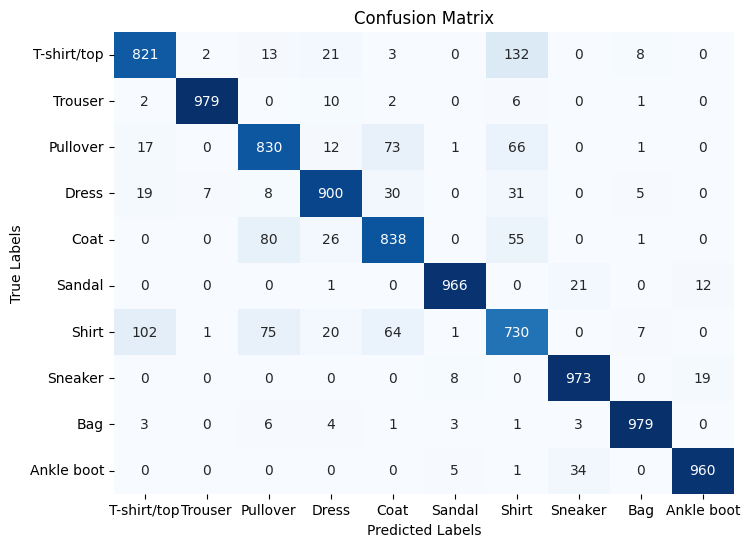

Test Accuracy: 0.8976
Test F1 Score: 0.8978
Confusion Matrix:
[[821   2  13  21   3   0 132   0   8   0]
 [  2 979   0  10   2   0   6   0   1   0]
 [ 17   0 830  12  73   1  66   0   1   0]
 [ 19   7   8 900  30   0  31   0   5   0]
 [  0   0  80  26 838   0  55   0   1   0]
 [  0   0   0   1   0 966   0  21   0  12]
 [102   1  75  20  64   1 730   0   7   0]
 [  0   0   0   0   0   8   0 973   0  19]
 [  3   0   6   4   1   3   1   3 979   0]
 [  0   0   0   0   0   5   1  34   0 960]]


In [76]:
# Test performance on the best model
print(f"Testing best model with learning rate {best_lr}")
test_accuracy, test_f1, conf_matrix = test_model(best_model, test_data, test_labels)


In [77]:
weights = best_model.get_weights()
with open("model_weights.pkl", "wb") as f:
    pickle.dump(weights, f)